# Condition Monitoring of Bearing vibration data collected under time-varying rotational speed conditions

Just in case Bonfiglioli does not allow me to use their data for my master thesis, I will test the complex-valued models and algorithms developed up to now over another, similar, dataset.

## Stuff for colab


In [1]:
#!unzip lib.zip

In [2]:
#!pip install dm-haiku

In [3]:
#!pip install torchaudio==0.9.1

In [4]:
#!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/v43hmbwxpm-1.zip

In [5]:
#!unzip v43hmbwxpm-1.zip -d data

## Description

Source: [Mendelay Data](https://data.mendeley.com/datasets/v43hmbwxpm/1) 

Related Paper: [Data in Brief](https://www.sciencedirect.com/science/article/pii/S2352340918314124)

The data contains vibration signals collected from bearings of different health conditions under time-varying rotational speed conditions.  There are 36 datasets in total. For each dataset, there are two experimental settings: bearing health condition and varying speed condition. The health conditions of the bearing include (i) healthy, (ii) faulty with an inner race defect, and (iii) faulty with an outer race defect. The operating rotational speed conditions are (i) increasing speed, (ii) decreasing speed, (iii) increasing then decreasing speed, and (iv) decreasing then increasing speed. Therefore, there are 12 different cases for the setting. To ensure the authenticity of the data, 3 trials are collected for each experimental setting which results in 36 datasets in total. Each dataset contains two channels: 'Channel_1' is vibration data measured by the accelerometer and 'Channel_2' is the rotational speed data measured by the encoder. All these data are sampled at 200,000Hz and the sampling duration is 10 seconds.

In [6]:
import numpy as np
import scipy.io
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchaudio.transforms import Spectrogram
sns.set_theme()
%matplotlib inline

Data are stored with the extension `.mat` from MATLAB and so we need to be careful when loading them.

## Data Generation

In [7]:
class MATLAB_DS(Dataset):
    
    def __init__(self, data_dir, split_rate=1, transform=None):
        
        file_list = glob.glob(os.path.join(data_dir, '*.mat'))
        raw_items = [scipy.io.loadmat(file)['Channel_1'] for file in file_list]
        raw_labels = [file.split('/')[-1].split('-')[0] for file in file_list]
        label_mapping = {'H':0, 'I':1, 'O':2}
        raw_labels = [label_mapping[label] for label in raw_labels]
        
        self.items = []
        self.labels = []
        rate = 200000
        sample_length = rate//split_rate
        for item_idx, item in enumerate(raw_items):
            for i in range(10*split_rate):
                self.items.append(item[i*sample_length:(i+1)*sample_length])
                self.labels.append(raw_labels[item_idx])
            
        self.length = len(self.items)
        self.transform = transform
        
        # Load also time-varying speeds
        self.speeds = [scipy.io.loadmat(file)['Channel_2'] for file in file_list]
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        
        sample = (self.items[idx], self.labels[idx])
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample

In [8]:
class ToTensor_onehot(object):
    """Convert sample to Tensors."""
    def __init__(self, n_classes=2):
        self.n_classes = n_classes

    def __call__(self, sample):
        x, y = sample
        y = np.eye(self.n_classes)[y]
        return ( torch.from_numpy(x.flatten()), torch.tensor(y) )
    
class Generate_Spectrograms(object):
    def __init__(self, n_fft=400):
        self.n_fft = n_fft
    def __call__(self, sample):
        x, y = sample
        spectrogram = Spectrogram(n_fft = self.n_fft, 
                                  win_length = None, 
                                  power = None,
                                  normalized = True, 
                                  return_complex = True)(x)

        spectrogram = spectrogram.unsqueeze(0)
        return (spectrogram, y)

There are two parameters that I want to fix before the data generation:
* the `n_fft` parameter representing the resolution of the complex spectrogram;
* the `split_rate` parameter that quantify in how many subsegments should we split each signal (in term of fraction of sample rate, i.e. length = sample_rate / split_rate = 200000 / split_rate.

Recall that each signal in the dataset is 10 seconds long, with a sample rate of 200000 Hz, and so it is constituted by a total of 2 millions points. Complessively, we have 36 sub-datasets, for a total of 36*3=108 input signals.

Let's start by fixing `split_rate` to 1: in such a way we can increase the size of the training set (that now is made by signals 50000 points long). Now, each 10s measure is split into 10 different subsegments 1s long, so complessively now we have 36*10=360 samples.

In [9]:
transform_to_spec = transforms.Compose([ToTensor_onehot(n_classes=3), Generate_Spectrograms(n_fft=800)])
data_ds = MATLAB_DS('data/mendeley_data/data', split_rate=1, transform=transform_to_spec)

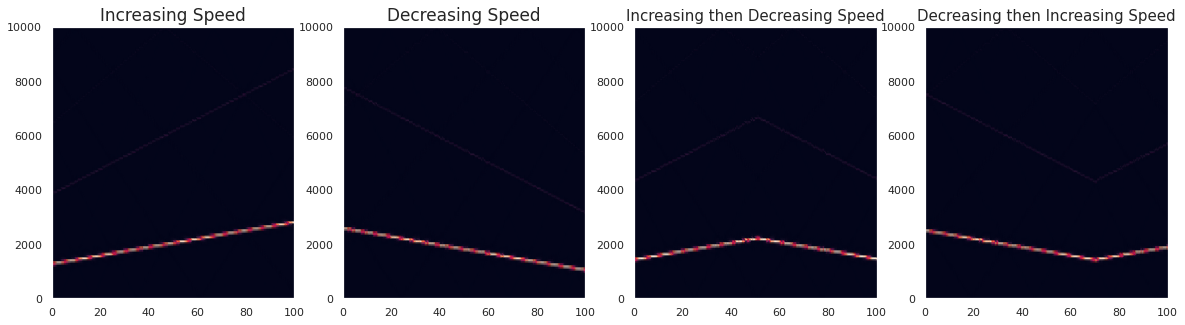

In [10]:
from scipy import signal

fig, ax = plt.subplots(1, 4, figsize=(20,5))

wave = data_ds.speeds[3]
f, t, Sxx = signal.spectrogram(x=wave.flatten(), fs=20000, nperseg=256)
ax[0].pcolormesh(t, f, Sxx, shading='gouraud')
ax[0].set_title('Increasing Speed', fontsize=17)
ax[0].set_xlim((0,100))

wave = data_ds.speeds[0]
f, t, Sxx = signal.spectrogram(x=wave.flatten(), fs=20000, nperseg=256)
ax[1].pcolormesh(t, f, Sxx, shading='gouraud')
ax[1].set_title('Decreasing Speed', fontsize=17)
ax[1].set_xlim((0,100))

wave = data_ds.speeds[1]
f, t, Sxx = signal.spectrogram(x=wave.flatten(), fs=20000, nperseg=256)
ax[2].pcolormesh(t, f, Sxx, shading='gouraud')
ax[2].set_title('Increasing then Decreasing Speed', fontsize=15)
ax[2].set_xlim((0,100))

wave = data_ds.speeds[2]
f, t, Sxx = signal.spectrogram(x=wave.flatten(), fs=20000, nperseg=256)
ax[3].pcolormesh(t, f, Sxx, shading='gouraud')
ax[3].set_title('Decreasing then Increasing Speed', fontsize=15)
ax[3].set_xlim((0,100));

In [11]:
#fig.savefig("mendelay_speed_changes.png", bbox_inches='tight')

Text(0.5, 1.0, 'Faulty (outer race defect)')

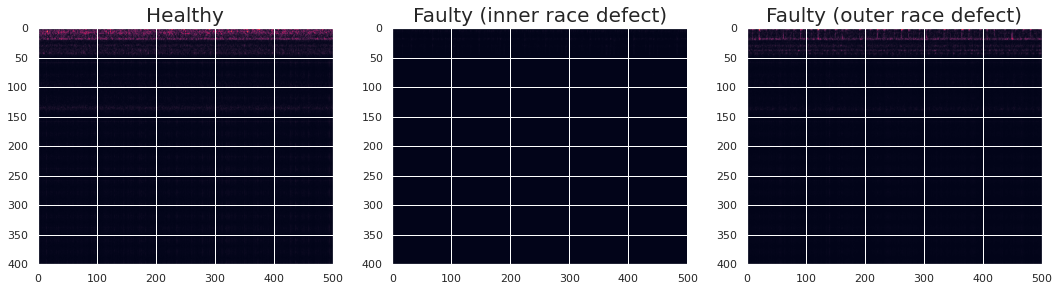

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

healthy_sample = data_ds[20][0][0]
faulty_inner = data_ds[30][0][0]
faulty_outer = data_ds[0][0][0]

ax[0].imshow(np.abs(healthy_sample))
ax[1].imshow(np.abs(faulty_inner))
ax[2].imshow(np.abs(faulty_outer))

ax[0].set_title('Healthy', fontsize=20)
ax[1].set_title('Faulty (inner race defect)', fontsize=20)
ax[2].set_title('Faulty (outer race defect)', fontsize=20)

Let's split the dataset into a training and a test set with proportions 75\%-25\%.

In [13]:
train_ds, val_ds = torch.utils.data.random_split(data_ds, [int(data_ds.__len__()*0.75), int(data_ds.__len__()*0.25)])
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

## Classification Task

In [14]:
import jax
import jax.numpy as jnp
import haiku as hk

In [15]:
from complex_nn.layers import Cmplx_Conv2D, Cmplx_Linear, Dropout, CmplxBatchNorm
from complex_nn.optimizers import cmplx_adam
from complex_nn.activations import cardioid
from complex_nn.Classifier_wrapper import Haiku_Classifier
from complex_nn.utils import small_training_summary

In [16]:
class CVCNN(hk.Module):
    
    def __init__(self, n_classes=2):
        
        super().__init__()
        self.conv1 = Cmplx_Conv2D(2, kernel_shape=3, stride=2, data_format='NCHW')
        self.conv2 = Cmplx_Conv2D(4, kernel_shape=3, stride=2, data_format='NCHW')
        self.conv3 = Cmplx_Conv2D(8, kernel_shape=3, stride=2, data_format='NCHW')

        self.flatten = hk.Flatten()
        
        self.avg_pool = hk.AvgPool(window_shape=3, strides=2, padding='SAME', channel_axis=1)

        self.fc1 = Cmplx_Linear(8)
        self.fc2 = Cmplx_Linear(4)
        self.fc3 = Cmplx_Linear(n_classes)

        self.dropout = Dropout(0.2)
        
        self.batchnorm_2D = CmplxBatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='NCHW')
        self.batchnorm_1D = CmplxBatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='NC')
        
        self.act = cardioid

    def __call__(self, z, is_training):
        z = self.act(self.conv1(z))
        z = self.batchnorm_2D(z, is_training)
        z = self.dropout(z, is_training)
        z = self.act(self.conv2(z))
        z = self.avg_pool(z)
        z = self.act(self.conv3(z))
        z = self.avg_pool(z)

        z = self.flatten(z)
        z = self.act(self.fc1(z))
        z = self.batchnorm_1D(z, is_training)
        z = self.dropout(z, is_training)
        z = self.act(self.fc2(z))

        z = self.fc3(z)

        return z

In [17]:
class RVCNN(hk.Module):

    def __init__(self, n_classes=2):
        
        super().__init__()

        self.real_conv1 = hk.Conv2D(2, kernel_shape=3, stride=2, data_format='NCHW')
        self.real_conv2 = hk.Conv2D(4, kernel_shape=3, stride=2, data_format='NCHW')
        self.real_conv3 = hk.Conv2D(8, kernel_shape=3, stride=2, data_format='NCHW')

        self.imag_conv1 = hk.Conv2D(2, kernel_shape=3, stride=2, data_format='NCHW')
        self.imag_conv2 = hk.Conv2D(4, kernel_shape=3, stride=2, data_format='NCHW')
        self.imag_conv3 = hk.Conv2D(8, kernel_shape=3, stride=2, data_format='NCHW')
        
        self.flatten = hk.Flatten()
        self.avg_pool = hk.AvgPool(window_shape=3, strides=2, padding='SAME', channel_axis=1)

        self.real_fc1 = hk.Linear(8)
        self.real_fc2 = hk.Linear(4)

        self.imag_fc1 = hk.Linear(8)
        self.imag_fc2 = hk.Linear(4)

        self.dropout = Dropout(0.2)
        
        self.real_batchnorm_2D = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='NCHW')
        self.real_batchnorm_1D = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='NC')

        self.imag_batchnorm_2D = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='NCHW')
        self.imag_batchnorm_1D = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='NC')
        
        self.out = hk.Linear(n_classes)

        self.act = jax.nn.relu
        

    def __call__(self, z, is_training):

        # Split the complex input into its real and imaginary parts
        x = z.real
        y = z.imag

        x = self.act(self.real_conv1(x))
        x = self.avg_pool(x)
        x = self.real_batchnorm_2D(x, is_training)
        x = self.dropout(x, is_training)
        x = self.act(self.real_conv2(x))
        x = self.avg_pool(x)
        x = self.act(self.real_conv3(x))
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.act(self.real_fc1(x))
        x = self.real_batchnorm_1D(x, is_training)
        x = self.dropout(x, is_training)
        x = self.act(self.real_fc2(x))

        y = self.act(self.imag_conv1(y))
        y = self.avg_pool(y)
        y = self.imag_batchnorm_2D(y, is_training)
        y = self.dropout(y, is_training)
        y = self.act(self.imag_conv2(y))
        y = self.avg_pool(y)
        y = self.act(self.imag_conv3(y))
        y = self.avg_pool(y)
        y = self.flatten(y)
        y = self.act(self.imag_fc1(y))
        y = self.imag_batchnorm_1D(y, is_training)
        y = self.dropout(y, is_training)
        y = self.act(self.imag_fc2(y))

        xy = jnp.concatenate([x,y], axis=-1)

        out = self.out(xy)

        return out

In [18]:
complex_hc1 = Haiku_Classifier()
#_ = complex_hc1.train(n_epochs = 100, 
#                     model = CVCNN, 
#                     optimizer = cmplx_adam(step_size=1e-3),
#                     train_dataloader = train_dl,
#                     test_dataloader = val_dl,
#                     verbose = False,
#                     n_classes = 3)

In [19]:
#complex_hc1.save_instance(name='mendeley_hf_1', model=CVCNN, path=os.getcwd() + '/trained_models')
complex_hc1.load_instance(class_path = 'notebook_results/trained_models/mendeley_hf_1.pkl',
                          model_path = 'notebook_results/trained_models/mendeley_hf_1_model.pkl',
                          init_dataloader = train_dl,
                          n_classes = 3
                         )

/home/mattia/anaconda3/envs/jax_env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3556: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")


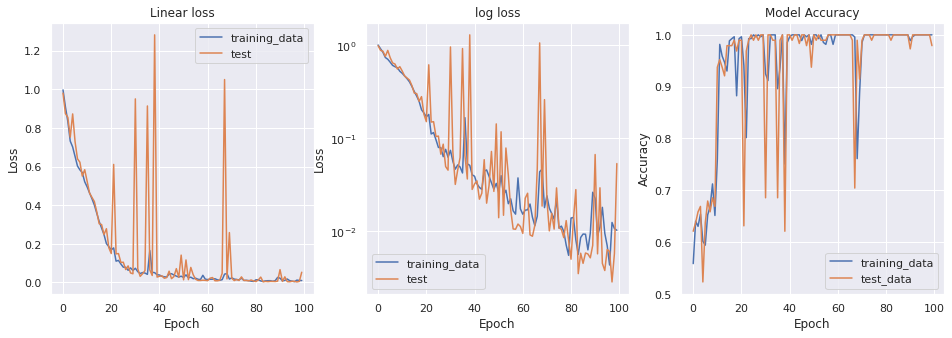

In [20]:
small_training_summary(complex_hc1.training_history)

In [21]:
real_hc1 = Haiku_Classifier()
#_ = real_hc1.train(n_epochs = 100, 
#                   model = RVCNN, 
#                   optimizer = cmplx_adam(step_size=1e-3),
#                   train_dataloader = train_dl,
#                   test_dataloader = val_dl,
#                   verbose = False,
#                   n_classes = 3)

In [22]:
#real_hc1.save_instance(name='mendeley_real_hf_1', model=RVCNN, path=os.getcwd() + '/trained_models')
real_hc1.load_instance(class_path = 'notebook_results/trained_models/mendeley_real_hf_1.pkl',
                       model_path = 'notebook_results/trained_models/mendeley_real_hf_1_model.pkl',
                       init_dataloader = train_dl,
                       n_classes = 3
                      )

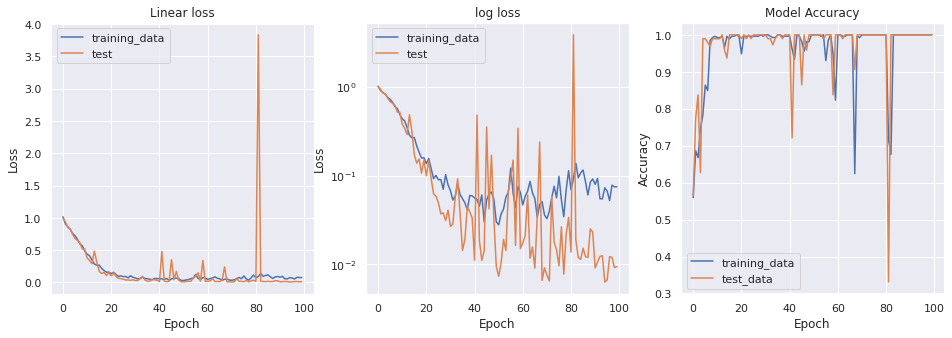

In [23]:
small_training_summary(real_hc1.training_history)

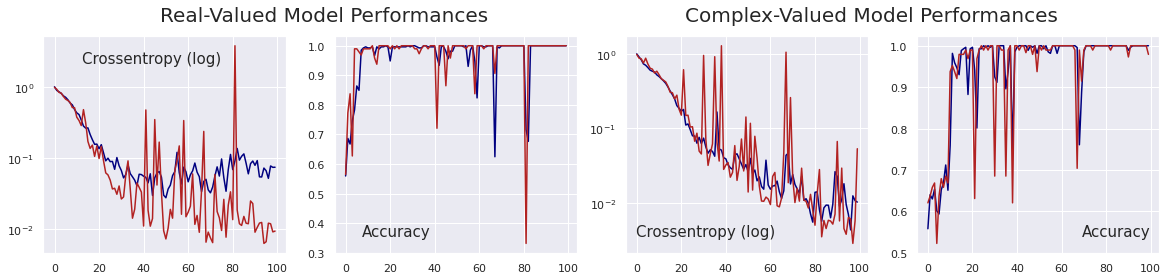

In [24]:
real_valued_history = real_hc1.training_history
complex_valued_history = complex_hc1.training_history

fig, ax = plt.subplots(1, 4, figsize=(20,4))

sns.lineplot(x=np.arange(len(real_valued_history['train_loss'])), y=real_valued_history['train_loss'], color='navy', ax=ax[0])
sns.lineplot(x=np.arange(len(real_valued_history['val_loss'])), y=real_valued_history['val_loss'], color='firebrick', ax=ax[0])

sns.lineplot(x=np.arange(len(real_valued_history['train_acc'])), y=real_valued_history['train_acc'], color='navy', ax=ax[1])
sns.lineplot(x=np.arange(len(real_valued_history['val_acc'])), y=real_valued_history['val_acc'], color='firebrick', ax=ax[1])

sns.lineplot(x=np.arange(len(complex_valued_history['train_loss'])), y=complex_valued_history['train_loss'], color='navy', ax=ax[2])
sns.lineplot(x=np.arange(len(complex_valued_history['val_loss'])), y=complex_valued_history['val_loss'], color='firebrick', ax=ax[2])

sns.lineplot(x=np.arange(len(complex_valued_history['train_acc'])), y=complex_valued_history['train_acc'], color='navy', ax=ax[3])
sns.lineplot(x=np.arange(len(complex_valued_history['val_acc'])), y=complex_valued_history['val_acc'], color='firebrick', ax=ax[3])

ax[0].set_yscale('log')
ax[2].set_yscale('log')

plt.figtext(0.2, 0.8, "Crossentropy (log)", va="center", ha="center", size=15)
plt.figtext(0.37, 0.2, "Accuracy", va="center", ha="center", size=15)
plt.figtext(0.585, 0.2, "Crossentropy (log)", va="center", ha="center", size=15)
plt.figtext(0.87, 0.2, "Accuracy", va="center", ha="center", size=15)


plt.figtext(0.32, 0.95, "Real-Valued Model Performances", va="center", ha="center", size=20)
plt.figtext(0.7, 0.95, "Complex-Valued Model Performances", va="center", ha="center", size=20);

In [25]:
#fig.savefig("mendeley_train_bad.pdf")

Very bad results! The training errors and accuracy behaves nicely, but the models seems to have bad generalization performances, given the high instability that we can notice on the validation lines.

Now, since the architecture is already quite small, and we have already used the canonical techniques to prevent overfitting (normalization, dropout) what we can do is acting directly on the dataset.

Our theory is that, further reducing the length of the input signal, even before constructing the spectrograms, we can reduce also the effects due to high variations in rotational speed, even from samples to samples.

From other tests, in fact, we noticed that using only datasets 'A' and 'B' or 'C' and 'D', so keeping only monotonic or non-monotonic speed samples together, the overfit and instability were more limited.

So let's move on considering, for example, signal of size 20000 (before was 50000). <br>
Now, our dataset will be composed of 36*100 = 3600 samples.

torch.Size([101, 101])


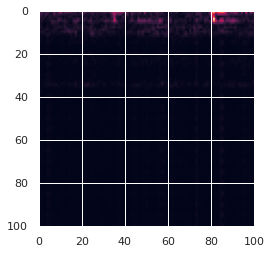

In [26]:
transform_to_spec = transforms.Compose([ToTensor_onehot(n_classes=3), Generate_Spectrograms(n_fft=200)])
data_ds = MATLAB_DS('data/mendeley_data/data/', split_rate=20, transform=transform_to_spec)

sample = data_ds[0][0][0]
print(sample.shape)
plt.imshow(np.abs(sample))

In [27]:
train_ds, val_ds = torch.utils.data.random_split(data_ds, [int(data_ds.__len__()*0.75), int(data_ds.__len__()*0.25)])
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False)

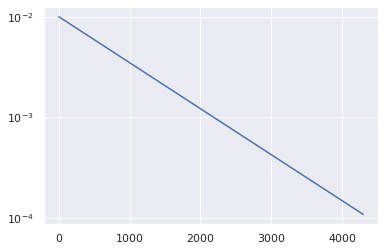

In [28]:
step_size = 0.01
decay_steps = 100
decay_rate = 0.9

lr_scheduler = jax.experimental.optimizers.exponential_decay(step_size=step_size, decay_steps=decay_steps, decay_rate=decay_rate)

n_epochs = 100
n_batches = len(train_dl)
steps = np.arange(n_epochs * n_batches)
plt.plot(steps, step_size*(decay_rate)**(steps/decay_steps))
plt.yscale('log')

In [29]:
complex_hc20 = Haiku_Classifier()
#_ = complex_hc20.train(n_epochs = 100, 
#                     model = CVCNN, 
#                     optimizer = cmplx_adam(step_size=lr_scheduler),
#                     train_dataloader = train_dl,
#                     test_dataloader = val_dl,
#                     verbose = False,
#                     n_classes = 3)

In [30]:
#complex_hc20.save_instance(name='mendeley_hf_20', model=CVCNN, path=os.getcwd() + '/trained_models')
complex_hc20.load_instance(class_path = 'notebook_results/trained_models/mendeley_hf_20.pkl',
                           model_path = 'notebook_results/trained_models/mendeley_hf_20_model.pkl',
                           init_dataloader = train_dl,
                           n_classes = 3
                          )

/home/mattia/anaconda3/envs/jax_env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3556: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")


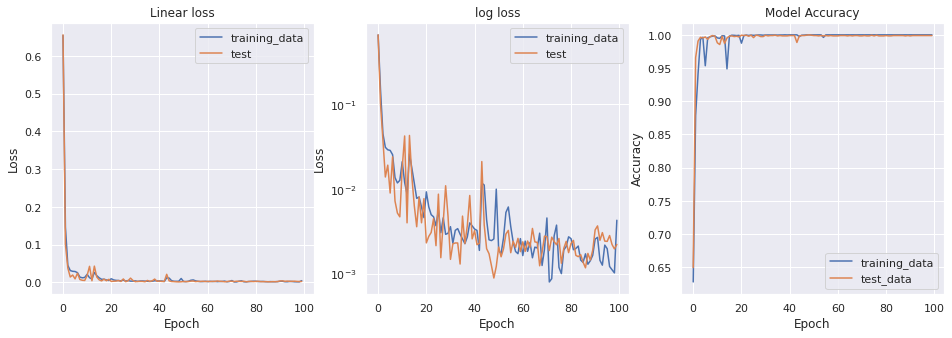

In [31]:
small_training_summary(complex_hc20.training_history)

In [32]:
real_hc20 = Haiku_Classifier()
#_ = real_hc20.train(n_epochs = 100, 
#                     model = RVCNN, 
#                     optimizer = cmplx_adam(step_size=lr_scheduler),
#                     train_dataloader = train_dl,
#                     test_dataloader = val_dl,
#                     verbose = False,
#                     n_classes = 3)

In [33]:
#real_hc20.save_instance(name='mendeley_real_hf_20', model=RVCNN, path=os.getcwd() + '/trained_models')
real_hc20.load_instance(class_path = 'notebook_results/trained_models/mendeley_real_hf_20.pkl',
                        model_path = 'notebook_results/trained_models/mendeley_real_hf_20_model.pkl',
                        init_dataloader = train_dl,
                        n_classes = 3
                        )

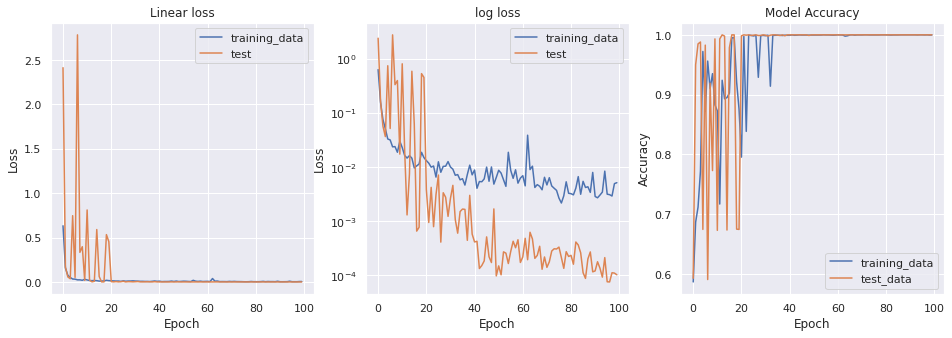

In [34]:
small_training_summary(real_hc20.training_history)

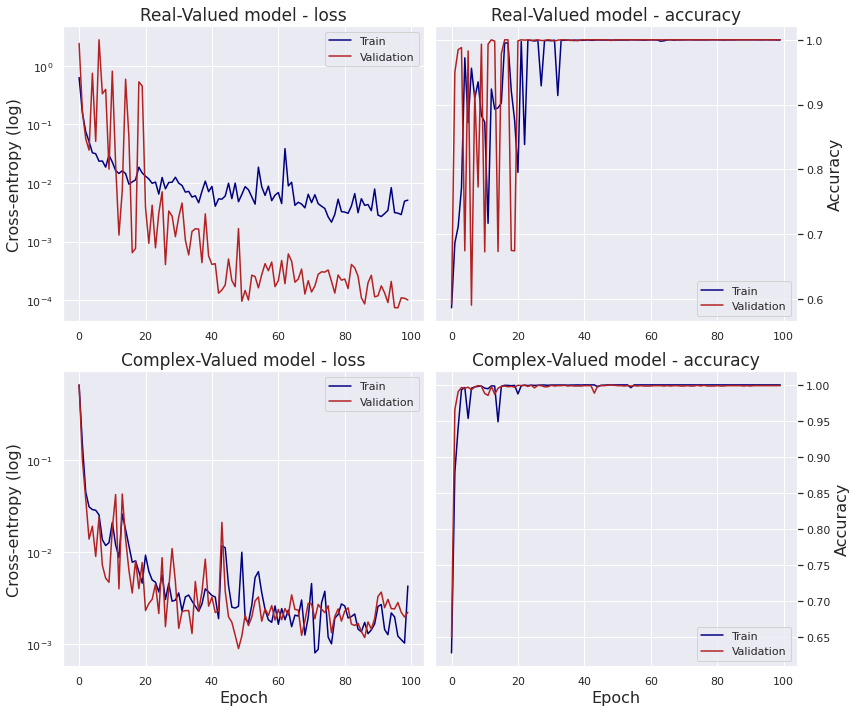

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))
ax = ax.flatten()

sns.lineplot(x=np.arange(len(real_hc20.training_history['train_loss'])), y=real_hc20.training_history['train_loss'], label='Train', color='navy', ax=ax[0])
sns.lineplot(x=np.arange(len(real_hc20.training_history['val_loss'])), y=real_hc20.training_history['val_loss'], label='Validation', color='firebrick', ax=ax[0])

sns.lineplot(x=np.arange(len(real_hc20.training_history['train_acc'])), y=real_hc20.training_history['train_acc'], label='Train', color='navy', ax=ax[1])
sns.lineplot(x=np.arange(len(real_hc20.training_history['val_acc'])), y=real_hc20.training_history['val_acc'], label='Validation', color='firebrick', ax=ax[1])


ax[0].set_title('Real-Valued model - loss', fontsize=17)
ax[0].set_ylabel('Cross-entropy (log)', fontsize=16)
ax[0].set_yscale('log')

ax[1].set_title('Real-Valued model - accuracy', fontsize=17)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')
ax[1].set_ylabel('Accuracy', fontsize=16)


sns.lineplot(x=np.arange(len(complex_hc20.training_history['train_loss'])), y=complex_hc20.training_history['train_loss'], label='Train', color='navy', ax=ax[2])
sns.lineplot(x=np.arange(len(complex_hc20.training_history['val_loss'])), y=complex_hc20.training_history['val_loss'], label='Validation', color='firebrick', ax=ax[2])

sns.lineplot(x=np.arange(len(complex_hc20.training_history['train_acc'])), y=complex_hc20.training_history['train_acc'], label='Train', color='navy', ax=ax[3])
sns.lineplot(x=np.arange(len(complex_hc20.training_history['val_acc'])), y=complex_hc20.training_history['val_acc'], label='Validation', color='firebrick', ax=ax[3])

ax[2].set_title('Complex-Valued model - loss', fontsize=17)
ax[2].set_ylabel('Cross-entropy (log)', fontsize=16)
ax[2].set_yscale('log')
ax[2].set_xlabel('Epoch', fontsize=16)

ax[3].set_title('Complex-Valued model - accuracy', fontsize=17)
ax[3].yaxis.tick_right()
ax[3].yaxis.set_label_position('right')
ax[3].set_ylabel('Accuracy', fontsize=16)
ax[3].set_xlabel('Epoch', fontsize=16)

fig.tight_layout()

In [36]:
#fig.savefig('mendeley_train_final.pdf')

Finally, this is a really nice behavior, with both models reaching the convergence and the perfect classification ($100\%$) accuracy. This means that our supposition was probably right, and a suitable approach to signal classification in case of time-varying speed conditions, is to fragment the original wave into smaller samples to reduced the effects of this non-stationarity. Of course, we believe that a necessary hypotheses for this to happen is some kind of monotony in the rotational speed variation: also in the third and fourth cases, we could clearly distinguish two regions in which the velocity behavior was monotonic and amenable to the first two. Probably, an higher irregularity in the rotational speed would have made also the classification more unstable and challenging, but we would need further more datasets to verify it.